In [1]:
import torchvision.transforms as transforms
from torchvision import datasets
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
from PIL import UnidentifiedImageError
from sklearn.model_selection import train_test_split

In [2]:
class Incidents12(datasets.VisionDataset):
    def __init__(self, root, transform=None):
        super().__init__(root, transform=transform)

        self.data = []
        self.targets = []
        self.errors = []

        # Load images from disk
        self.classes = os.listdir(root)[1:]
        paths = [root + self.classes[i] + '/' for i in range(len(self.classes))]

        for p in paths:
          for _, _, files in os.walk(p):
            for filename in files:
                try:
                    img = Image.open(p+filename).convert("RGB")
                    self.data.append(img)
                    self.targets.append(paths.index(p))
                except (UnidentifiedImageError, FileNotFoundError):
                    self.errors.append(p+filename)

        # Resampling to equalize the amount of samples per class
        classes_count = {i: 0 for i in range(len(self.classes))}
        for target in self.targets:
            classes_count[target] += 1
        min_class = min(classes_count, key=classes_count.get)

        df = pd.DataFrame(data={"Image": self.data, "Label": self.targets})
        samples_class = [df[df["Label"] == i] for i in range(len(self.classes))]
        classes_under = [samples_class[i].sample(df[df["Label"] == min_class].shape[0]) for i in range(len(self.classes))]
        new_df = pd.concat(classes_under, axis=0).reset_index()
        
        self.data = new_df["Image"]
        self.targets = new_df["Label"]


    def __getitem__(self, index: int): 
        img, target = self.data[index], self.targets[index]

        if self.transform is not None:
            img = self.transform(img)
            img = img.numpy().transpose((1,2,0))

        return img, target

    def __len__(self):
        return(len(self.data))

    def to_dataframe(self):
        tensor_images = [self[i][0] for i in range(len(self.data))]
        return(pd.DataFrame(data={"Image": tensor_images, "Label": self.targets}))

In [3]:
os.listdir("datasets/incidents")

['.ipynb_checkpoints',
 'ice storm',
 'car accident',
 'oil spill',
 'wildfire',
 'earthquake',
 'airplane accident',
 'volcanic eruption',
 'collapsed',
 'tornado',
 'nuclear explosion',
 'bicycle accident',
 'flooded']

In [4]:
transform = transforms.Compose([
    # resize
    transforms.Resize(256),
    # center-crop
    transforms.CenterCrop(224),
    # to-tensor
    transforms.ToTensor(),
    # normalize
    transforms.Normalize([0.04544269, 0.04544269, 0.04544269],
                         [0.21317291, 0.21317291, 0.21317291])
])

In [5]:
dataset = Incidents12("datasets/incidents/", transform=transform)

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [14]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [85]:
print(len(train_dataset))
print(len(test_dataset))

2188
548


In [18]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=4)

In [19]:
def imshow(inp, title=None):
    mean = np.array([0.04544269, 0.04544269, 0.04544269])
    std = np.array([0.21317291, 0.21317291, 0.21317291])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [20]:
df = dataset.to_dataframe()

In [21]:
len(df)

2736

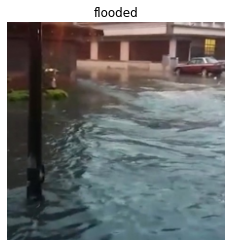

In [22]:
import random
r = random.randint(0,len(dataset.data))
imshow(df["Image"][r], dataset.classes[df["Label"][r]])

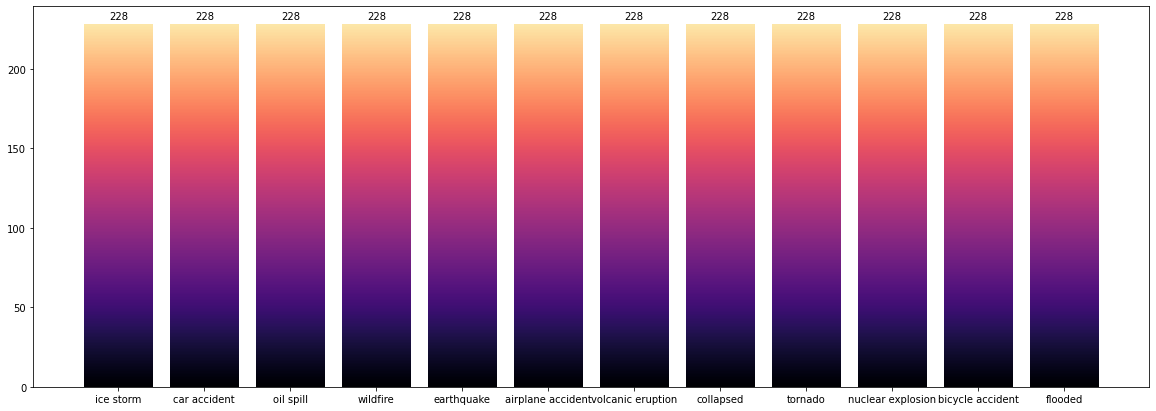

In [25]:
fig, ax = plt.subplots(1,1,figsize=(20,7))
rects = plt.bar(dataset.classes,df["Label"].value_counts().sort_index())

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*height, '%d'%int(height),
                ha='center', va='bottom')
autolabel(rects)

def gradientbars_sliced(bars):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=0, origin='lower',
                  vmin=ymin, vmax=ymax, cmap='magma')
    ax.axis([xmin, xmax, ymin, ymax])

gradientbars_sliced(rects)
plt.show()

 ### Neural network

In [76]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda

In [77]:
import torch.nn as nn
from torchvision import models

alexnet = models.alexnet(pretrained=True)

## freeze the layers
for param in alexnet.parameters():
    param.requires_grad = False
    
# Modify the last layer
number_features = alexnet.classifier[6].in_features
features = list(alexnet.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, len(dataset.classes))])
alexnet.classifier = torch.nn.Sequential(*features)

alexnet = alexnet.to(device)
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [78]:
criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

In [79]:
import time
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        train_loss = 0

        # Iterate over data.
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs = inputs.permute(0,3,2,1)
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs  = model(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

            print('{} Loss: {:.4f}'.format(
               'train', train_loss / train_size))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
       time_elapsed // 60, time_elapsed % 60))

    return model

In [80]:
alexnet = train_model(alexnet, criterion, optimizer_ft, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0048
train Loss: 0.0089
train Loss: 0.0138
train Loss: 0.0180
train Loss: 0.0229
train Loss: 0.0272
train Loss: 0.0309
train Loss: 0.0363
train Loss: 0.0413
train Loss: 0.0468
train Loss: 0.0520
train Loss: 0.0539
train Loss: 0.0566
train Loss: 0.0624
train Loss: 0.0664
train Loss: 0.0709
train Loss: 0.0738
train Loss: 0.0787
train Loss: 0.0821
train Loss: 0.0848
train Loss: 0.0927
train Loss: 0.0977
train Loss: 0.1017
train Loss: 0.1076
train Loss: 0.1130
train Loss: 0.1166
train Loss: 0.1188
train Loss: 0.1253
train Loss: 0.1280
train Loss: 0.1323
train Loss: 0.1381
train Loss: 0.1420
train Loss: 0.1451
train Loss: 0.1511
train Loss: 0.1579
train Loss: 0.1616
train Loss: 0.1644
train Loss: 0.1674
train Loss: 0.1798
train Loss: 0.1815
train Loss: 0.1887
train Loss: 0.1907
train Loss: 0.1937
train Loss: 0.1982
train Loss: 0.2012
train Loss: 0.2061
train Loss: 0.2073
train Loss: 0.2128
train Loss: 0.2154
train Loss: 0.2181
train Loss: 0.2185
train Loss

In [84]:
correct = 0
total = 0
alexnet.eval()

with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.permute(0,3,2,1)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of Alexnet algorithm over the training set of {} images : {}%.".format(len(trainloader), 100*correct/total))

Accuracy of Alexnet algorithm over the training set of 547 images : 99.95429616087752%.


In [83]:
correct = 0
total = 0
alexnet.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.permute(0,3,2,1)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of Alexnet algorithm over the testing set of {} images : {}%.".format(len(testloader), 100*correct/total))

Accuracy of Alexnet algorithm over the testing set of 137 images : 60.03649635036496%.
